# **Variational AutoEncoder, a bit KL Divergence, with PyTorch**

Reference : 

- https://www.kaggle.com/code/rvislaywade/visualizing-mnist-using-a-variational-autoencoder
- https://www.kaggle.com/code/tingsongou/variational-autoencoder-with-pytroch

# I. Preliminaries

In [8]:
try:
    from torchsummary import summary
except:
    !pip install torch-summary
    from torchsummary import summary

In [9]:
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Project running on device: ", DEVICE)

Project running on device:  cuda


In [10]:
config = {
    "batch_size": 64,
    "epochs": 10,
    "lr": 1e-3,
    "hidden_dim": 2
}

labels = ["T-shirt/top", 
          "Trouser", 
          "Pullover", 
          "Dress", 
          "Coat", 
          "Sandla", 
          "Shirt", 
          "Sneaker", 
          "Bag", 
          "Ankle boot"]

# II. Dataset

## Loading FashionMNIST Dataset

In [11]:
def collate_fn(batch):
    
    process = transforms.Compose([
                transforms.ToTensor(),
                transforms.Pad([2])]
                )
    
    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)
    
    y = torch.LongTensor([data[1] for data in batch])
    return x, y

In [12]:
%%capture
train_data = FashionMNIST("./MNIST_DATA", train=True, download=True)
valid_data = FashionMNIST("./MNIST_DATA", train=False, download=True)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)

Inspecting train data: 
Batch shape:  torch.Size([64, 1, 32, 32])


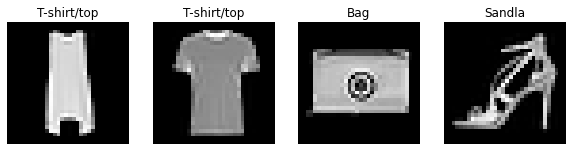

In [13]:
print("Inspecting train data: ")
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))
    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    break

# III. Variational AutoEncoder

In [14]:
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048

## Encoder

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()
        
        # bottleneck dimentionality
        self.output_dim = output_dim

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
    
        # convolutional layer hyper parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()

        self.flatten = nn.Flatten()
        
        # Adding mean and sigma projections
        self.mu = nn.Linear(2048, self.output_dim)
        self.sigma = nn.Linear(2048, self.output_dim)
        
        # Initialize a 'target' normal distribution for KL divergence
        self.norm = torch.distributions.Normal(0, 1)
        
        # tracking the KL divergence
        self.kl = 0
    
    
    def get_convs(self):
        model = nn.Sequential()
        for i in range(self.layers):
            
            if i == 0: model.append(nn.Conv2d(1, 
                                              self.channels[i], 
                                              kernel_size=self.kernels[i],
                                              stride=self.strides[i],
                                              padding=1))
            
            else: model.append(nn.Conv2d(self.channels[i-1], 
                                         self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding=1))
            
            if self.use_batchnorm:
                model.append(nn.BatchNorm2d(self.channels[i]))
            
            model.append(nn.GELU()) # Here we use GELU as activation function
            
            if self.use_dropout:
                model.append(nn.Dropout2d(0.25))

        return model
    
    
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        
        # getting mean/sigma projections
        x_mu = self.mu(x)
        x_sigma = torch.exp(self.sigma(x))
        
        # reparameterization trick
        z = x_mu + x_sigma * self.norm.sample(x_mu.shape).to(DEVICE)
        
        # compute the KL divergence and store in the class
        self.kl = (x_sigma ** 2 + x_mu ** 2 
                    - torch.log(x_sigma) - 0.5).sum()
        
        return z # we only return the sample points to feed to the decoder

    
# encoder = Encoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
# summary(encoder, (1, 32, 32))

## Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        super(Decoder, self).__init__()
        
        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim
        
        # Conv layer hypyer parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES
        
        # In decoder, we first do fc project, then conv layers
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)
    

    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            
            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )
            
            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1], 
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )
            
            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        return self.output(x)
    
# decoder = Decoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
# summary(decoder, (1, 2))

## Variational AutoEncoder

In [17]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=config["hidden_dim"], use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=config["hidden_dim"], use_batchnorm=True, use_dropout=False)
        
    def forward(self, x):
        x = self.encoder(x)
        reconst = self.decoder(x)
        return reconst

model = AutoEncoder().to(DEVICE)
summary(model, (1, 32, 32))
pass

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 2]                   --
|    └─Sequential: 2-1                   [-1, 128, 4, 4]           --
|    |    └─Conv2d: 3-1                  [-1, 32, 16, 16]          320
|    |    └─BatchNorm2d: 3-2             [-1, 32, 16, 16]          64
|    |    └─GELU: 3-3                    [-1, 32, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            18,496
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─GELU: 3-6                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-7                  [-1, 128, 4, 4]           73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 4, 4]           256
|    |    └─GELU: 3-9                    [-1, 128, 4, 4]           --
|    └─Flatten: 2-2                      [-1, 2048]                --
|    └─Linear: 2-3                       [-1, 2]                   4,098
|

# IV. Experiment

## Training setup

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()
steps = 0

In [19]:
config["kl_weight"] = 0.7

def train(model, dataloader, optimizer, save_distrib=False):
    global steps
    
    model.train()
    train_loss = 0.0
    
    # Process tqdm bar
    batch_bar = tqdm(total=len(dataloader), 
                     leave=False, position=0, desc="Train")

    for i, batch in enumerate(dataloader):
        
        optimizer.zero_grad()
        x = batch[0].to(DEVICE)
        
        with torch.cuda.amp.autocast():
            # get reconstruct image
            x_hat = model(x) 
            # MSE loss between original image and reconstructed one
            loss_mse = ((x - x_hat)**2).sum() / config["batch_size"]
            # KL divergence between encoder distrib. and N(0,1) distrib. 
            loss_kl = model.encoder.kl / config["batch_size"]
            # Get weighted loss
            loss = (loss_mse * (1 - config["kl_weight"]) 
                    + loss_kl * config["kl_weight"])

        train_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        
        batch_bar.set_postfix(
            loss = f"{train_loss/(i+1):.4f}",
            mse_loss = f"{loss_mse:.4f}",
            kl_loss = f"{loss_kl:.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        
        batch_bar.update()
        torch.cuda.empty_cache()
        del x, x_hat
    
    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss

In [20]:
def validate(model, dataloader):
    
    model.eval()
    valid_loss = 0.0
    
    # Progress tqdm bar
    batch_bar = tqdm(total=len(dataloader),
                     leave=False, position=0, desc="Validation")
    
    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)
        
        with torch.no_grad():
            x_hat = model(x)
        loss_mse = ((x - x_hat)**2).sum() / config["batch_size"]
        loss_kl = model.encoder.kl / config["batch_size"]
        loss = loss_mse * (1 - config["kl_weight"]) + loss_kl * config["kl_weight"]
        
        valid_loss += loss.item()
        
        batch_bar.set_postfix(
            loss = f"{train_loss/(i+1):.4f}",
            mse_loss = f"{loss_mse:.4f}",
            kl_loss = f"{loss_kl:.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )

        batch_bar.update()
        torch.cuda.empty_cache()
        del x, x_hat
    
    batch_bar.close()
    valid_loss /= len(dataloader)
    
    return valid_loss

In [22]:
# Train the model
train_loss_hist = []
valid_loss_hist = []

for i in range(config["epochs"]):
    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, optimizer, save_distrib=False)
    valid_loss = validate(model, valid_loader)
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    print(f"Epoch {i+1}/{config['epochs']}: \t Train loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")

Epoch 1/10: 	 Train loss: 11.7606	 Validation loss: 11.3441	lr: 0.0010


Epoch 2/10: 	 Train loss: 11.3726	 Validation loss: 11.0619	lr: 0.0010


Epoch 3/10: 	 Train loss: 11.1397	 Validation loss: 11.0333	lr: 0.0010


Epoch 4/10: 	 Train loss: 11.0109	 Validation loss: 10.8165	lr: 0.0010


Epoch 5/10: 	 Train loss: 10.9223	 Validation loss: 10.7752	lr: 0.0010


Epoch 6/10: 	 Train loss: 10.8434	 Validation loss: 10.7602	lr: 0.0010


Epoch 7/10: 	 Train loss: 10.8003	 Validation loss: 10.6821	lr: 0.0010


Epoch 8/10: 	 Train loss: 10.7769	 Validation loss: 10.6812	lr: 0.0010


Epoch 9/10: 	 Train loss: 10.7315	 Validation loss: 10.5894	lr: 0.0010


Epoch 10/10: 	 Train loss: 10.7153	 Validation loss: 10.6542	lr: 0.0010


## Analysis

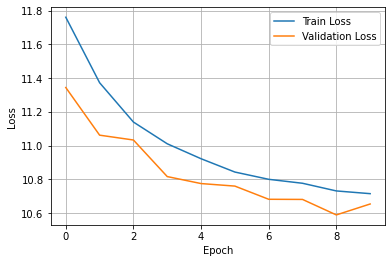

In [23]:
def plot_hist():
    x_seq = list(range(config["epochs"]))
    plt.plot(x_seq, train_loss_hist, label="Train Loss")
    plt.plot(x_seq, valid_loss_hist, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_hist()

In [24]:
def show_plot(use_tsne=False):
    
    model.eval()
    
    points = []
    labels_idx = []
    
    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        z = model.encoder(img)
        points.extend(z.detach().cpu().numpy())
        labels_idx.extend(label.detach().cpu().numpy())
        del img, label
    
    points = np.array(points)
    labels_idx = np.array(labels_idx)
    
    if use_tsne:
        points = TSNE(n_components=2, learning_rate="auto", 
                      perplexity=70, n_iter=1000, init="pca").fit_transform(points)

    plt.figure(figsize=(10, 9))
    plt.title(f"KL Weight = {config['kl_weight']}, MSE Weight = {1 - config['kl_weight']:.1f}")
    c_map = matplotlib.cm.get_cmap("tab10")
    
    for i, label in enumerate(labels):
        filters = np.where(labels_idx==i)
        pts = points[filters]
        lbs = labels_idx[filters]
        
        col = [c_map(i)] * len(pts)
        
        plt.scatter(x=pts[:, 0], y=pts[:, 1], s=2.0, 
                     c=col, alpha=0.9, zorder=2, label=label)
        plt.grid(True, color="lightgray", alpha=1.0, zorder=0)
    
    plt.legend(markerscale=4.0)
    plt.show()

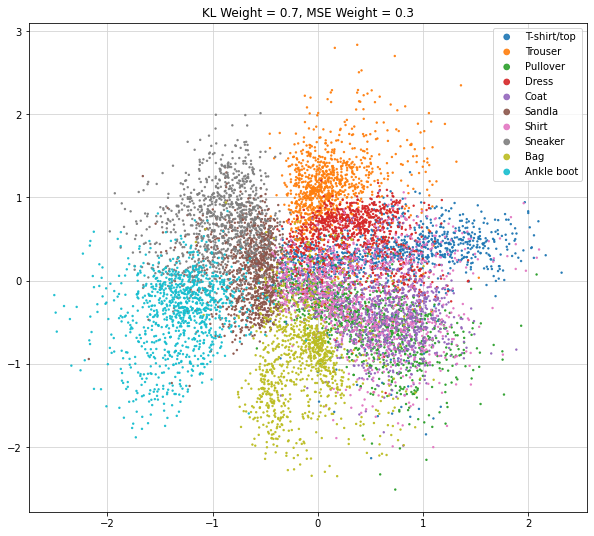

In [25]:
show_plot()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


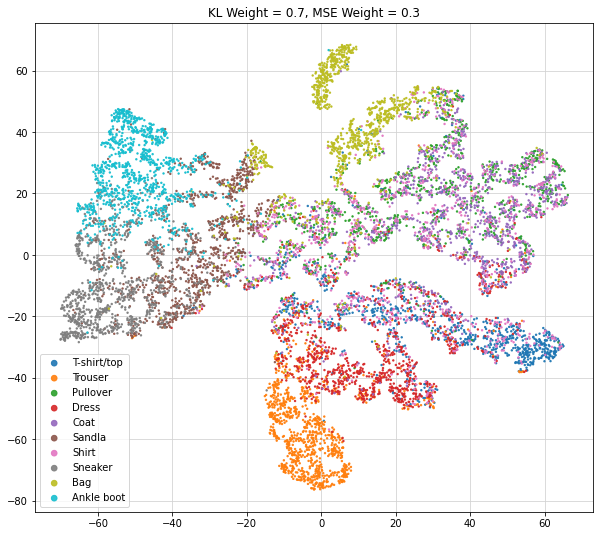

In [26]:
show_plot(use_tsne=True) # with t-sne enabled

# V. Interpolation

In [61]:
def interpolate(class_a:int, class_b:int, num_steps:int):
    model.eval()

    step_size = 1.0 / num_steps

    sample_a = None
    sample_b = None

    # retriving data that corresponded to the class indices
    for i, data in enumerate(train_loader):
        img, label = data
        sample_a = img[label==class_a] if sample_a == None else sample_a
        sample_b = img[label==class_b] if sample_b == None else sample_b
        if len(sample_a) != 0 and len(sample_b) != 0:
            break

    # encoding both images to get sampled z values of both classes
    with torch.no_grad():
        z_a = model.encoder(sample_a.to(DEVICE))[0].reshape(1, -1)
        z_b = model.encoder(sample_b.to(DEVICE))[0].reshape(1, -1)

    print("z_a: ", z_a)
    print("z_b: ", z_b)

    # interpolation
    diff = z_b - z_a
    steps = torch.arange(0.0, 1.0 + step_size, step_size, 
                        dtype=torch.float, device=z_a.device).reshape(-1, 1)
    zs = z_a + steps * diff

    print(zs)
    with torch.no_grad():
        out_imgs = model.decoder(zs)
    
    # flatten images
    out_imgs = out_imgs.permute(0, 1, 3, 2)
    out_imgs = out_imgs.detach().cpu().numpy().reshape(-1, 32).T
    print(out_imgs.shape)

    return out_imgs

z_a:  tensor([[-0.2324,  1.2156]], device='cuda:0')
z_b:  tensor([[0.3000, 0.2991]], device='cuda:0')
tensor([[-0.2324,  1.2156],
        [-0.1437,  1.0629],
        [-0.0549,  0.9101],
        [ 0.0338,  0.7573],
        [ 0.1225,  0.6046],
        [ 0.2113,  0.4518],
        [ 0.3000,  0.2991],
        [ 0.3887,  0.1463]], device='cuda:0')
(32, 256)


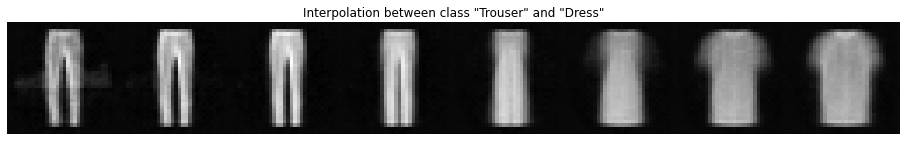

In [62]:
class_a = 1
class_b = 3
num_steps = 6

interp_imgs = interpolate(class_a, class_b, num_steps)

plt.figure(figsize=(16, 10))
plt.title(f"Interpolation between class \"{labels[class_a]}\" and \"{labels[class_b]}\"")
plt.imshow(interp_imgs, cmap="gray")
plt.axis("off")
plt.show()

In [30]:

from scipy.stats import norm

In [34]:
n = 20 
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

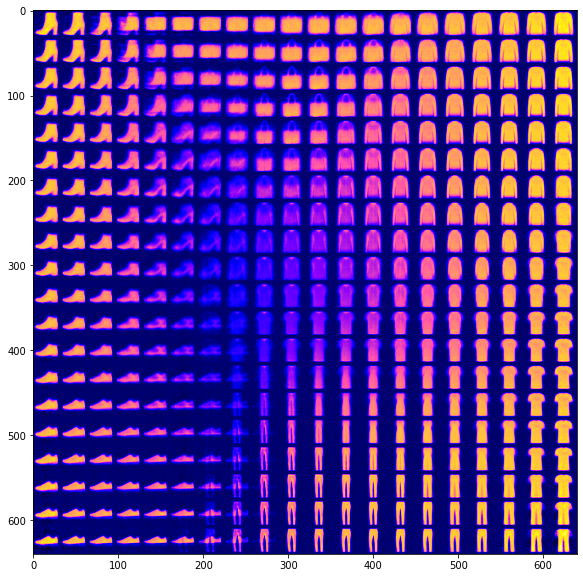

In [78]:
# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # z_sample = np.tile(z_sample, config['batch_size']).reshape(config['batch_size'], 2)
        z_sample = torch.from_numpy(z_sample).float().to(DEVICE)
        x_decoded = model.decoder(z_sample) #.predict(z_sample, batch_size=batch_size)
        out_imgs = x_decoded.permute(0, 1, 3, 2)
        out_imgs = out_imgs.detach().cpu().numpy().reshape(-1, 32).T
#         print(out_imgs.shape)
#         digit = x_decoded.reshape(digit_size, digit_size).detach().cpu()
#         print(digit.shape) # torch.size([32,32])
#         break
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = out_imgs

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  